<a href="https://colab.research.google.com/github/Anjasfedo/data-analysis/blob/main/Copy_of_Template_Submission_Akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Gemstones
- **Nama:** M. Anjasfedo Afridiansah
- **Email:** fedoafridiansah@gmail.com
- **ID Dicoding:** anjasfedo

## Import Semua Packages/Library yang Digunakan

In [89]:
import os
import shutil
import zipfile
import random
from random import sample
from shutil import copyfile
from pathlib import Path
from collections import Counter
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras
import tensorflowjs as tfjs
import kagglehub
warnings.simplefilter(action='ignore', category=FutureWarning)

In [90]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available. Training will use GPU.")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found. Training will use CPU.")

print(tf.__version__)

GPU is available. Training will use GPU.
2.18.0


In [91]:
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, img_to_array, load_img
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)

## Data Preparation

### Data Loading

In [92]:
path = kagglehub.dataset_download("muhammadmuzamil5500/gemstones")
dataset_path = '/kaggle/input/gemstones/FYP_Datasets'
combined_dir = '/content/datasets'
os.makedirs(combined_dir, exist_ok=True)
splits = ['train', 'test', 'validation']

def copy_images_efficient(src_split, dst_dir):
    src_dir = os.path.join(dataset_path, src_split)
    if not os.path.exists(src_dir):
        return
    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        class_dst = os.path.join(dst_dir, class_name)
        os.makedirs(class_dst, exist_ok=True)
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for file_name in img_files:
            shutil.copy2(os.path.join(class_path, file_name), os.path.join(class_dst, file_name))
        print(f"Copied {len(img_files)} images to {class_dst}")

for split in splits:
    copy_images_efficient(split, combined_dir)

print("Combined Dataset contents:", os.listdir(combined_dir))
for class_name in sorted(os.listdir(combined_dir)):
    class_path = os.path.join(combined_dir, class_name)
    if os.path.isdir(class_path):
        num_img = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {num_img} images")

Copied 500 images to /content/datasets/Fake_Emerald
Copied 500 images to /content/datasets/Turquoise
Copied 507 images to /content/datasets/Emerald
Copied 500 images to /content/datasets/Ruby
Copied 536 images to /content/datasets/Fake_Ruby
Copied 500 images to /content/datasets/Fake_Turquoise
Copied 250 images to /content/datasets/Fake_Emerald
Copied 250 images to /content/datasets/Turquoise
Copied 250 images to /content/datasets/Emerald
Copied 250 images to /content/datasets/Ruby
Copied 250 images to /content/datasets/Fake_Ruby
Copied 250 images to /content/datasets/Fake_Turquoise
Copied 250 images to /content/datasets/Fake_Emerald
Copied 250 images to /content/datasets/Turquoise
Copied 250 images to /content/datasets/Emerald
Copied 250 images to /content/datasets/Ruby
Copied 250 images to /content/datasets/Fake_Ruby
Copied 250 images to /content/datasets/Fake_Turquoise
Combined Dataset contents: ['Ruby', 'Fake_Turquoise', 'Fake_Ruby', 'Emerald', 'Fake_Emerald', 'Turquoise']
Emerald:

Classes in dataset: ['Ruby', 'Fake_Turquoise', 'Fake_Ruby', 'Emerald', 'Fake_Emerald', 'Turquoise']
Ruby: 1500 images
Fake_Turquoise: 1499 images
Fake_Ruby: 1536 images
Emerald: 1507 images
Fake_Emerald: 1500 images
Turquoise: 1500 images


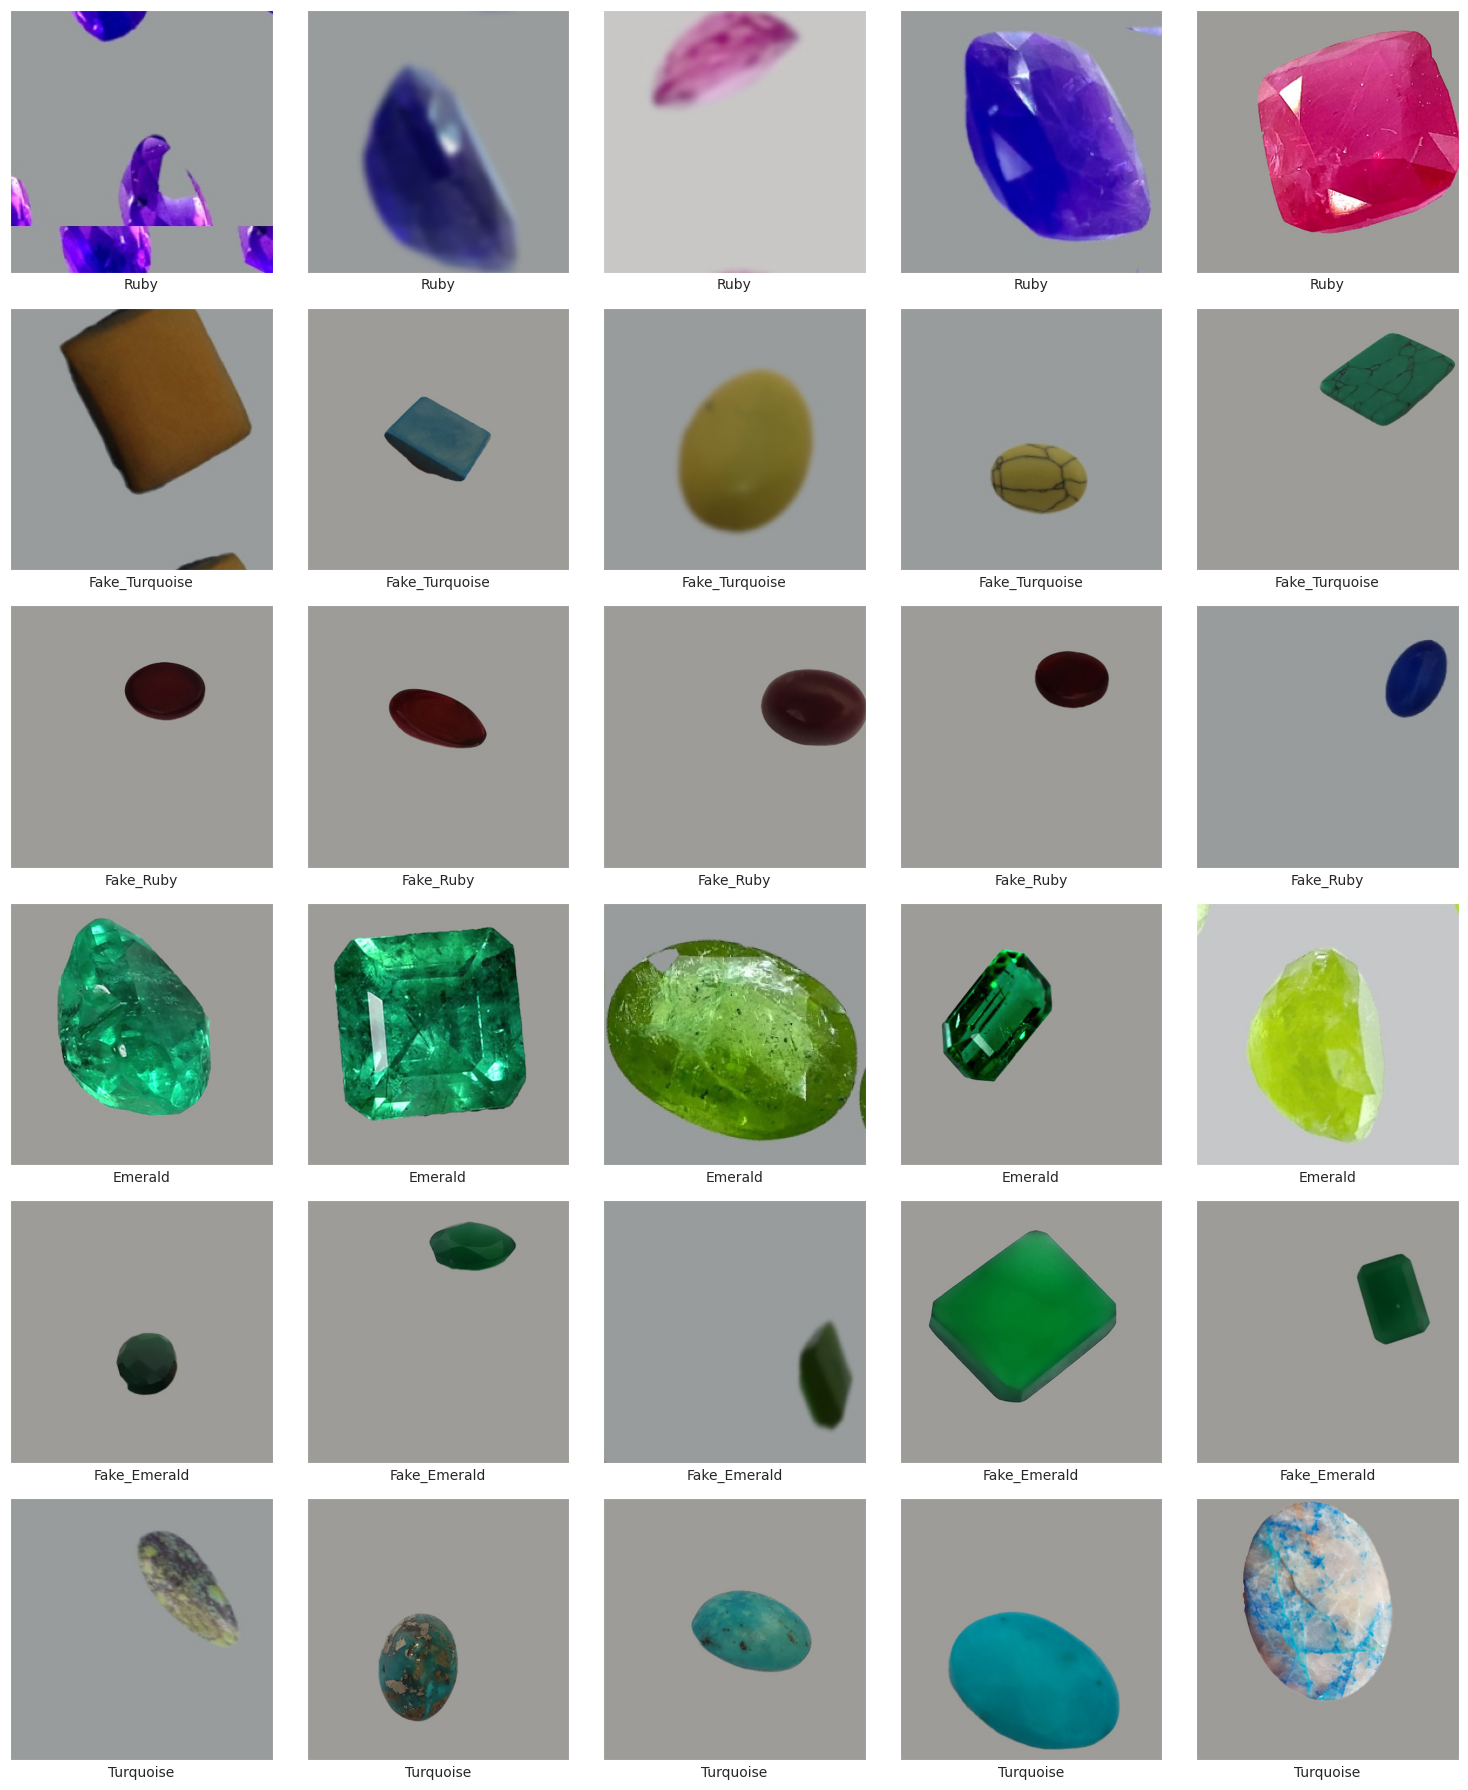

In [93]:
combined_dir = '/content/datasets'
class_names = [d for d in os.listdir(combined_dir) if os.path.isdir(os.path.join(combined_dir, d))]
gemstone_images = {class_name: os.listdir(os.path.join(combined_dir, class_name)) for class_name in class_names}

print("Classes in dataset:", list(gemstone_images.keys()))
for class_name, images in gemstone_images.items():
    print(f"{class_name}: {len(images)} images")

fig, axs = plt.subplots(len(class_names), 5, figsize=(15, 3 * len(class_names)))
if len(class_names) == 1:
    axs = np.expand_dims(axs, 0)
for i, class_name in enumerate(class_names):
    images = np.random.choice(gemstone_images[class_name], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(combined_dir, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
fig.tight_layout()
plt.show()

                                                path  \
0                /content/datasets/Ruby/Ruby_519.jpg   
1  /content/datasets/Ruby/Ruby_augmented_image_36...   
2  /content/datasets/Ruby/Ruby_augmented_image_10...   
3                /content/datasets/Ruby/Ruby_537.jpg   
4                /content/datasets/Ruby/Ruby_304.jpg   

                      file_name labels  
0                  Ruby_519.jpg   Ruby  
1  Ruby_augmented_image_360.jpg   Ruby  
2  Ruby_augmented_image_109.jpg   Ruby  
3                  Ruby_537.jpg   Ruby  
4                  Ruby_304.jpg   Ruby  
labels
Fake_Ruby         1536
Emerald           1507
Fake_Emerald      1500
Ruby              1500
Turquoise         1500
Fake_Turquoise    1499
Name: count, dtype: int64


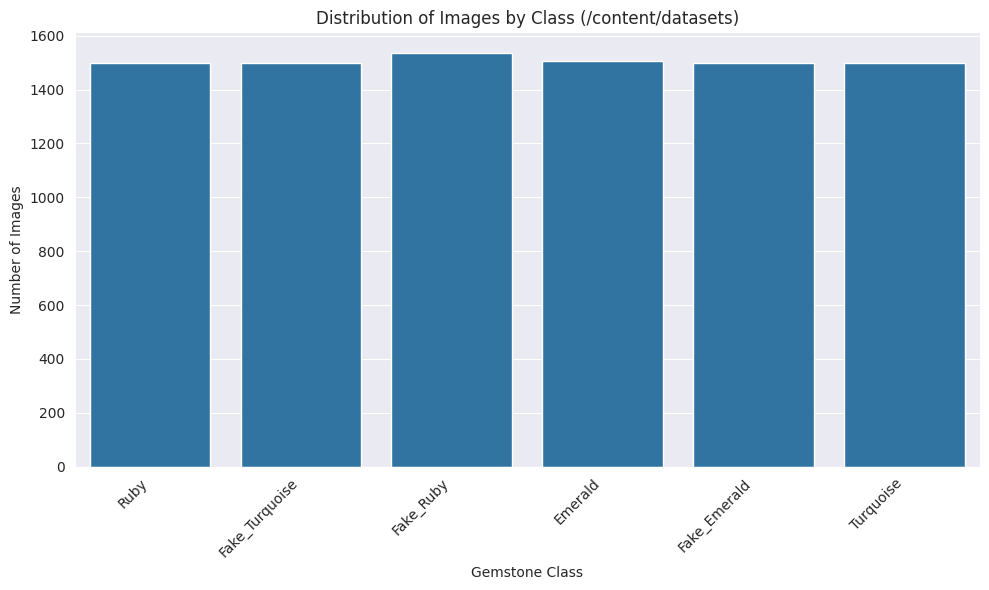

In [94]:
def plot_distribution(dataset_dir):
    file_name = []
    labels = []
    full_path = []
    image_ext = ('.jpg', '.jpeg', '.png')
    class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    for class_name in class_dirs:
        class_path = os.path.join(dataset_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(image_ext)]
        file_name.extend(image_files)
        labels.extend([class_name] * len(image_files))
        full_path.extend([os.path.join(class_path, f) for f in image_files])

    if full_path:
        distribution = pd.DataFrame({
            "path": full_path,
            "file_name": file_name,
            "labels": labels
        })
        print(distribution.head())
        print(distribution['labels'].value_counts())
        plt.figure(figsize=(10, 6))
        sns.set_style("darkgrid")
        plot_data = sns.countplot(x='labels', data=distribution)
        plot_data.set_title(f'Distribution of Images by Class ({dataset_dir})')
        plot_data.set_xlabel('Gemstone Class')
        plot_data.set_ylabel('Number of Images')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No images found in the specified dataset.")

combined_dataset_path = '/content/datasets'
plot_distribution(combined_dataset_path)

### Data Preprocessing

In [95]:
def preprocess_img(img):
    if img is None:
        raise ValueError("Image is None (could not be read)")
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    return cv2.resize(img, (224, 224))

def anticlockwise_rotation(img):
    img = preprocess_img(img)
    sudut = random.randint(0,180)
    return rotate(img, sudut, mode='wrap')

def clockwise_rotation(img):
    img = preprocess_img(img)
    sudut = random.randint(0,180)
    return rotate(img, -sudut, mode='wrap')

def flip_up_down(img):
    img = preprocess_img(img)
    return np.flipud(img)

def add_brightness(img):
    img = preprocess_img(img)
    return adjust_gamma(img, gamma=0.5, gain=1)

def blur_image(img):
    img = preprocess_img(img)
    return cv2.GaussianBlur(img, (9,9), 0)

def sheared(img):
    img = preprocess_img(img)
    transform = AffineTransform(shear=0.2)
    return warp(img, transform, mode="wrap")

def warp_shift(img):
    img = preprocess_img(img)
    transform = AffineTransform(translation=(0,40))
    return warp(img, transform, mode="wrap")

In [96]:
dataset_path = '/content/datasets'
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue
    print(f"Processing class: {class_name}")
    images = [os.path.join(class_path, name) for name in os.listdir(class_path) if name.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not images:
        continue
    images_to_generate = 500
    generated = 0
    while generated < images_to_generate:
        image_path = random.choice(images)
        try:
            original_image = io.imread(image_path)
            transformed_image = original_image
            n_transforms = random.randint(1, len(transformations))
            for _ in range(n_transforms):
                func = random.choice(list(transformations.values()))
                transformed_image = func(transformed_image)
            new_image_path = os.path.join(class_path, f"{class_name}_augmented_image_{generated+1}.jpg")
            cv2.imwrite(new_image_path, img_as_ubyte(transformed_image))
            generated += 1
        except Exception as e:
            print(f"Could not process image {image_path}: {e}")

Processing class: Ruby
Processing class: Fake_Turquoise
Processing class: Fake_Ruby
Processing class: Emerald
Processing class: Fake_Emerald
Processing class: Turquoise


                                                path  \
0                /content/datasets/Ruby/Ruby_519.jpg   
1  /content/datasets/Ruby/Ruby_augmented_image_36...   
2  /content/datasets/Ruby/Ruby_augmented_image_10...   
3                /content/datasets/Ruby/Ruby_537.jpg   
4                /content/datasets/Ruby/Ruby_304.jpg   

                      file_name labels  
0                  Ruby_519.jpg   Ruby  
1  Ruby_augmented_image_360.jpg   Ruby  
2  Ruby_augmented_image_109.jpg   Ruby  
3                  Ruby_537.jpg   Ruby  
4                  Ruby_304.jpg   Ruby  
labels
Fake_Ruby         1536
Emerald           1507
Fake_Emerald      1500
Ruby              1500
Turquoise         1500
Fake_Turquoise    1499
Name: count, dtype: int64


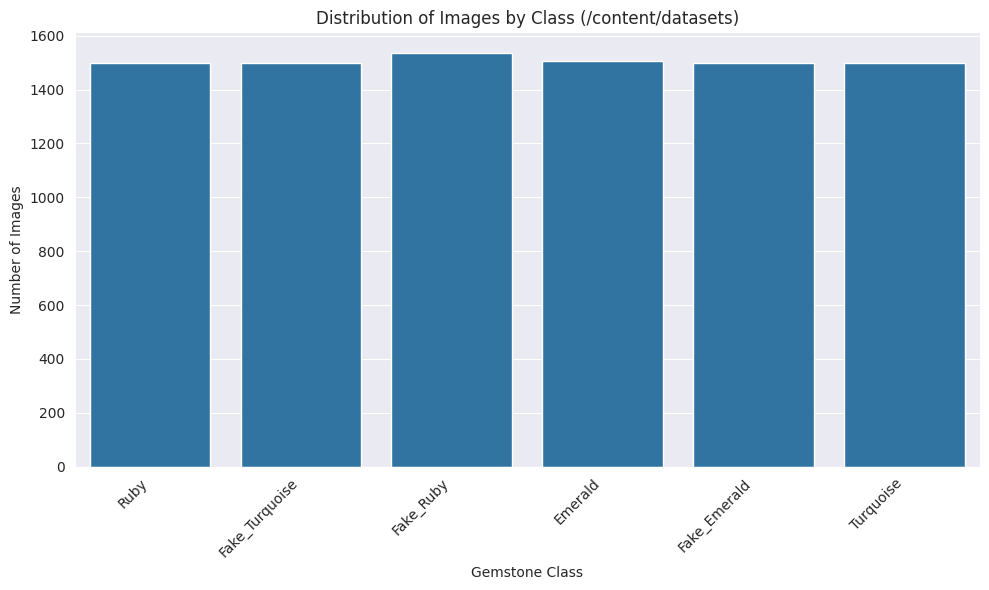

In [97]:
combined_dataset_path = '/content/datasets'
plot_distribution(combined_dataset_path)

In [98]:
mypath = '/content/datasets'
image_ext = ('.jpg', '.jpeg', '.png')

file_name = []
labels = []
full_path = []

for root, _, files in os.walk(mypath):
    label = os.path.basename(root)
    img_files = [f for f in files if f.lower().endswith(image_ext)]
    file_name.extend(img_files)
    labels.extend([label] * len(img_files))
    full_path.extend([os.path.join(root, f) for f in img_files])

df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})
print(df.groupby('labels').size())

labels
Emerald           1507
Fake_Emerald      1500
Fake_Ruby         1536
Fake_Turquoise    1499
Ruby              1500
Turquoise         1500
dtype: int64


In [99]:
X = df['path']
y = df['labels']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=300, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=300, stratify=y_trainval)

In [100]:
df_tr = pd.DataFrame({'path': X_train.values, 'labels': y_train.values, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test.values, 'labels': y_test.values, 'set': 'test'})
df_val = pd.DataFrame({'path': X_val.values, 'labels': y_val.values, 'set': 'validation'})

In [101]:
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print(df_all.groupby(['set', 'labels']).size())

print(df_all.sample(5))

datasource_path = "/content/datasets/"
dataset_path = "/content/dataset-final/"
os.makedirs(dataset_path, exist_ok=True)

set         labels        
test        Emerald           302
            Fake_Emerald      300
            Fake_Ruby         307
            Fake_Turquoise    300
            Ruby              300
            Turquoise         300
train       Emerald           964
            Fake_Emerald      960
            Fake_Ruby         983
            Fake_Turquoise    959
            Ruby              960
            Turquoise         960
validation  Emerald           241
            Fake_Emerald      240
            Fake_Ruby         246
            Fake_Turquoise    240
            Ruby              240
            Turquoise         240
dtype: int64
                                                   path        labels  \
7707  /content/datasets/Fake_Emerald/Fake_Emerald_au...  Fake_Emerald   
6306  /content/datasets/Fake_Emerald/(400, 400, 3)_5...  Fake_Emerald   
1836        /content/datasets/Turquoise/Turqoise_37.jpg     Turquoise   
627            /content/datasets/Emerald/Emerld_914.jpg 

In [102]:
for index, row in tqdm(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

100%|██████████| 9042/9042 [00:00<00:00, 14294.19it/s]


In [104]:
TRAIN_DIR = "/content/dataset-final/train/"
TEST_DIR = "/content/dataset-final/test/"
VALIDATION_DIR = "/content/dataset-final/validation/"

classes = ['Fake_Emerald', 'Ruby', 'Turquoise', 'Fake_Ruby', 'Fake_Turquoise', 'Emerald']

for class_name in classes:
    train_class_dir = os.path.join(TRAIN_DIR, class_name)
    test_class_dir = os.path.join(TEST_DIR, class_name)
    validation_class_dir = os.path.join(VALIDATION_DIR, class_name)

    if os.path.exists(train_class_dir):
        print(f"Total number of {class_name} images in training set: {len(os.listdir(train_class_dir))}")
    else:
        print(f"{class_name} class is missing from the training set.")

    if os.path.exists(test_class_dir):
        print(f"Total number of {class_name} images in test set: {len(os.listdir(test_class_dir))}")
    else:
        print(f"{class_name} class is missing from the test set.")

    if os.path.exists(validation_class_dir):
        print(f"Total number of {class_name} images in validation set: {len(os.listdir(validation_class_dir))}")
    else:
        print(f"{class_name} class is missing from the validation set.")

Total number of Fake_Emerald images in training set: 960
Total number of Fake_Emerald images in test set: 300
Total number of Fake_Emerald images in validation set: 240
Total number of Ruby images in training set: 960
Total number of Ruby images in test set: 300
Total number of Ruby images in validation set: 240
Total number of Turquoise images in training set: 960
Total number of Turquoise images in test set: 300
Total number of Turquoise images in validation set: 240
Total number of Fake_Ruby images in training set: 983
Total number of Fake_Ruby images in test set: 307
Total number of Fake_Ruby images in validation set: 246
Total number of Fake_Turquoise images in training set: 959
Total number of Fake_Turquoise images in test set: 300
Total number of Fake_Turquoise images in validation set: 240
Total number of Emerald images in training set: 964
Total number of Emerald images in test set: 302
Total number of Emerald images in validation set: 241


In [105]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    VALIDATION_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 4631 images belonging to 6 classes.
Found 1447 images belonging to 6 classes.
Found 1809 images belonging to 6 classes.


## Modelling

In [106]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Conv2D(32, (4, 4), padding='same', activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Conv2D(32, (7, 7), padding='same', activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
classes = ['Fake_Emerald', 'Ruby', 'Turquoise', 'Fake_Ruby', 'Fake_Turquoise', 'Emerald']

class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, class_name))) for class_name in classes]
total_samples = sum(class_counts)

class_weights = {i: (total_samples / count) / len(classes) for i, count in enumerate(class_counts)}

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights
)

Epoch 1/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 35s 241ms/step - accuracy: 0.7268 - loss: 1.0113 - val_accuracy: 0.8279 - val_loss: 0.7601
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 224ms/step - accuracy: 0.7434 - loss: 0.9419 - val_accuracy: 0.3918 - val_loss: 5.4555
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 227ms/step - accuracy: 0.7663 - loss: 0.9124 - val_accuracy: 0.6697 - val_loss: 1.3078
Epoch 4/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 228ms/step - accuracy: 0.7626 - loss: 0.8926 - val_accuracy: 0.7871 - val_loss: 0.8077
Epoch 5/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.7958 - loss: 0.8203 - val_accuracy: 0.6828 - val_loss: 1.2241
Epoch 6/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.8061 - loss: 0.7685 - val_accuracy: 0.7885 - val_loss: 0.7953
Epoch 7/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.8291 - loss: 0.7431 - val_accuracy: 0.8307 - val_loss: 0.6119
Epoch 8/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 222ms/step - accuracy: 0.8307 - loss: 0

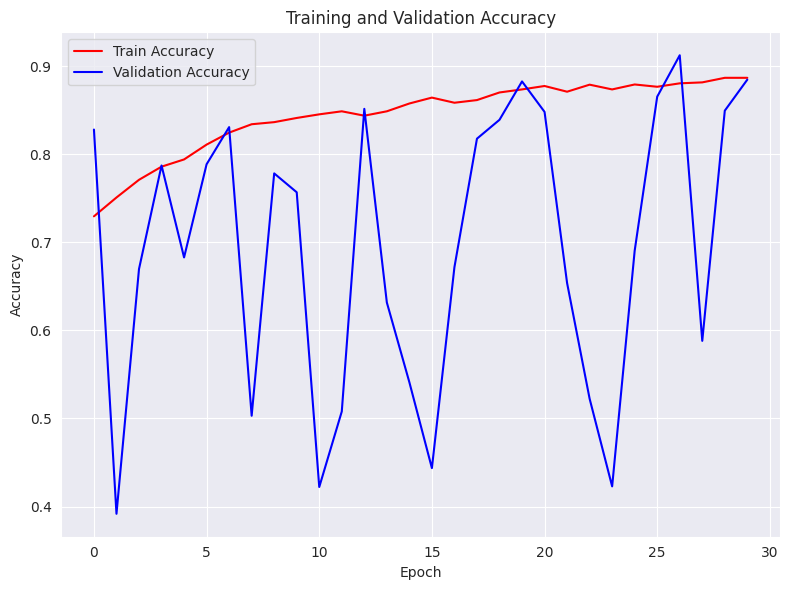

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluasi dan Visualisasi

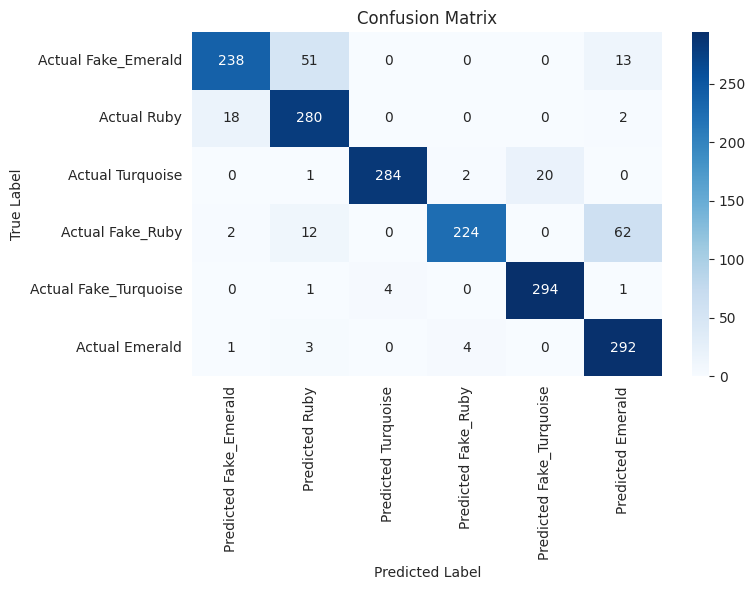

                precision    recall  f1-score   support

  Fake_Emerald     0.9189    0.7881    0.8485       302
          Ruby     0.8046    0.9333    0.8642       300
     Turquoise     0.9861    0.9251    0.9546       307
     Fake_Ruby     0.9739    0.7467    0.8453       300
Fake_Turquoise     0.9363    0.9800    0.9577       300
       Emerald     0.7892    0.9733    0.8716       300

      accuracy                         0.8911      1809
     macro avg     0.9015    0.8911    0.8903      1809
  weighted avg     0.9019    0.8911    0.8905      1809



In [112]:
test_generator.reset()
preds = model.predict(test_generator, verbose=0)
pred_labels = np.argmax(preds, axis=1)
labels = [0, 1, 2, 3, 4, 5]
class_names = ['Fake_Emerald', 'Ruby', 'Turquoise', 'Fake_Ruby', 'Fake_Turquoise', 'Emerald']

cm = confusion_matrix(test_generator.classes, pred_labels, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"Actual {name}" for name in class_names], columns=[f"Predicted {name}" for name in class_names])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
print(classification_report(test_generator.classes, pred_labels, target_names=class_names, digits=4))

## Konversi Model

In [70]:
os.makedirs('saved_model', exist_ok=True)
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136717513311440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513314704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513314896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513316048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513313552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513315280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513316432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513317968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513317200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513318544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513317008: T

In [72]:
model.save('h5_model/model.h5')

In [73]:
os.makedirs('tflite', exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpmanf634x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136717513311440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513314704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513314896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513316048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513313552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513315280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513316432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513317968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513317200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136717513318544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367175133170

In [74]:
class_names = list(train_generator.class_indices.keys())
with open('tflite/label.txt', 'w') as f:
    for cls in class_names:
        f.write(f"{cls}\n")

In [75]:
class_names = list(train_generator.class_indices.keys())
import os
os.makedirs('tflite', exist_ok=True)
with open('tflite/label.txt', 'w') as f:
    for cls in class_names:
        f.write(f"{cls}\n")

In [77]:
!tensorflowjs_converter --input_format keras h5_model/model.h5 tfjs_model

2025-06-20 14:13:51.373316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750428831.405935   30910 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750428831.415997   30910 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [78]:
os.makedirs('tfjs_model', exist_ok=True)

tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [85]:
!pip freeze >> requirements.txt

In [ ]:
# 5.5 Buat README.md
readme_content = """
# Proyek Klasifikasi Gambar: Gemstones

## Deskripsi Proyek

Repositori ini berisi kode dan notebook untuk proyek klasifikasi gambar menggunakan TensorFlow dan Keras. Proyek ini dibuat sebagai bagian dari submission akhir untuk kelas Machine Learning Pemula. Tujuannya adalah untuk membangun model deep learning yang mampu membedakan berbagai jenis batu permata asli dan palsu menggunakan citra digital.

- **Nama:** M. Anjasfedo Afridiansah
- **Email:** fedoafridiansah@gmail.com
- **ID Dicoding:** anjasfedo

## Struktur Direktori

```
submission/
├── tfjs_model/          # Model dalam format TensorFlow.js
├── tflite/              # Model dalam format TFLite & label
├── saved_model/         # Model dalam format TensorFlow SavedModel
├── h5_model/            # Model dalam format h5
├── notebook.ipynb       # Notebook utama berisi seluruh kode dan penjelasan
├── README.md            # Penjelasan proyek dan instruksi
└── requirements.txt     # Daftar library yang digunakan
```

## Penjelasan Kode

### 1. Import Library

Semua library yang dibutuhkan diimpor di awal, termasuk library untuk data science (`numpy`, `pandas`, `matplotlib`, `seaborn`), image processing (`opencv`, `skimage`, `PIL`), serta library machine learning dan deep learning (`scikit-learn`, `tensorflow`, `keras`).

### 2. Data Preparation

Bagian ini melakukan:
- **Loading Data:** Menyalin file citra ke folder sesuai kelasnya.
- **Augmentasi:** Mempersiapkan data dengan augmentasi agar model lebih general.
- **Pembagian Dataset:** Membagi dataset menjadi train, validation, dan test.

### 3. Model Development

Membangun model CNN menggunakan TensorFlow/Keras.

### 4. Training dan Evaluasi

Model dilatih pada data train dan divalidasi pada data validation. Setelah training, model dievaluasi pada data test untuk melihat performanya. Hasil evaluasi menggunakan confusion matrix dan classification report.

### 5. Konversi Model

Setelah model dilatih, model diekspor ke berbagai format:
- **SavedModel** (`saved_model/`): Format untuk deployment di TensorFlow Serving atau TFLite.
- **TFLite** (`tflite/model.tflite`): Model untuk deployment pada perangkat mobile/edge.
- **TFJS** (`tfjs_model/`): Model untuk deployment di aplikasi web dengan TensorFlow.js.
- **h5** (`h5_model/model.h5`): Model dengan format h5.

## Daftar Library

Semua dependensi ada di `requirements.txt`. Untuk install secara manual:
```bash
pip install -r requirements.txt
```

## Catatan

- Pastikan seluruh dependensi telah terinstal sebelum menjalankan notebook.

---

Selamat mencoba dan semoga sukses dalam submission!
"""
with open('README.md', 'w') as f:
    f.write(readme_content)